# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

Set up constants:

In [ ]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250403-14-58-53 - 14-58-53


Read in data, report on data read and validate distance array:

In [4]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\five_d.txt.
It is known that the shortest distance is 19


Evaluate cost function and clear cache:

In [5]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [6]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [7]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [8]:
hot_start_list = hot_start(distance_array, sdl.locations)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                              sdl.locations, 
                                              sdl.gray, 
                                              sdl.formulation
                                              )
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
sdl.hot_start_dist = float(distance_tensor)
print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

The hot start location list is [0, 3, 2, 1, 4]
This is equivalent to a binary list: [1, 1, 0, 1, 0]
bin_hot_start_list_tensor = tensor([[1, 1, 0, 1, 0]])
The hot start distance is 21.00, compared to a best distance of 19.00.


Set up input as repeated hot start tensor calculated above:

In [9]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

Set up model with gradient required:

In [10]:

model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [11]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

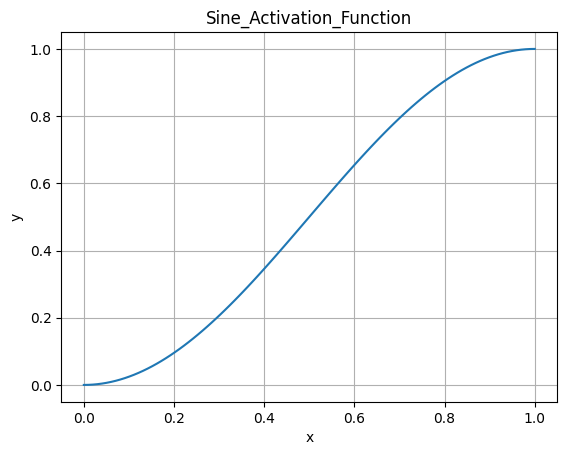

In [12]:
plot_sine_activation()

Print out model details including graph

tensor([25., 27., 25.,  ..., 21., 27., 21.], device='cuda:0',
       grad_fn=<CostFunctionBackward>)
{'fc1.weight': Parameter containing:
tensor([[ 1.4772, -0.2783,  0.5822, -0.0724,  0.6875],
        [-0.1852,  0.2100, -0.0363,  0.7945, -0.1798],
        [ 0.1257, -0.2480,  0.8991,  0.0090, -0.4574],
        [-0.0662,  0.4786,  0.5406,  0.7706,  0.2613],
        [-0.5504,  0.3248, -0.4885,  0.2921,  1.0695]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.0076, -0.1049,  0.2282, -0.3180,  0.0370], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 1.4772, -0.2783,  0.5822, -0.0724,  0.6875],
        [-0.1852,  0.2100, -0.0363,  0.7945, -0.1798],
        [ 0.1257, -0.2480,  0.8991,  0.0090, -0.4574],
        [-0.0662,  0.4786,  0.5406,  0.7706,  0.2613],
        [-0.5504,  0.3248, -0.4885,  0.2921,  1.0695]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([ 0.0076, 

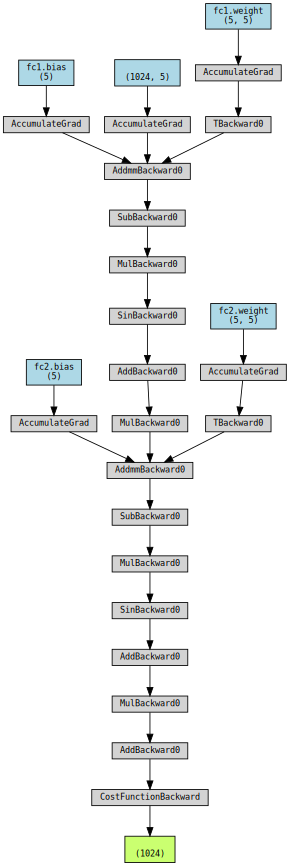

In [13]:
output = model(my_input)
#lowest_cost = float(output)
lowest_cost = output.min()
#print(f'Output = {output:.3f}')
print(output)
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

In [14]:
model(my_input)

tensor([27., 27., 21.,  ..., 21., 27., 27.], device='cuda:0',
       grad_fn=<CostFunctionBackward>)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

ValueError: Optimizer SPSA not recognized

Train model and print out results:

In [ ]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.save_results_to_csv()
sdl.save_detailed_results()

In [ ]:
sdl

In [ ]:
print(sdl.best_dist)

In [ ]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f} and the hot start cost was {sdl.hot_start_dist:.3f}.')#

Plot loss ratio by epoch:

In [ ]:
sdl.save_plot()


Print out parameters:

In [ ]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)